In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

from keras_preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from sklearn.metrics import *

In [2]:
input_dir = '/kaggle/input'

sample_dir = os.path.join(input_dir, 'sample/')
csv_dir = os.path.join(input_dir, 'nih-data-generator')
images_dir = os.path.join(sample_dir, 'sample/sample/images')

In [3]:
training_file = os.path.join(csv_dir, 'train_data.csv')

training_df = pd.read_csv(training_file, index_col=0)

training_df['pneumonia'] = training_df['pneumonia'].astype(str)

In [10]:
batch_size = 64
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255.,  
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.1, 
    width_shift_range=0.1, 
    rotation_range=30,
    shear_range = 0.1,
    zoom_range=0.2
)

In [11]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=image_size,
    subset='training',
    color_mode='rgb'
)

Found 5606 validated image filenames belonging to 2 classes.


In [6]:
num_classes = 1

IMG_WIDTH, IMG_HEIGHT = image_size

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

base_model.trainable = False

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2156, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1280, activation = 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(540, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation = 'sigmoid')
])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2156)              54091884  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2156)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              2760960   
_________________________________________________________

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
EPOCHS = 100

model_file = os.path.join('model.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='loss', 
                    patience=5,
                    restore_best_weights=True
                 )

history = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 [==============================] - 172s 2s/step - loss: 1.2779 - accuracy: 0.5062
Epoch 2/100
88/88 [==============================] - 166s 2s/step - loss: 0.6900 - accuracy: 0.5535
Epoch 3/100
88/88 [==============================] - 165s 2s/step - loss: 0.6597 - accuracy: 0.6015
Epoch 4/100
88/88 [==============================] - 162s 2s/step - loss: 0.6542 - accuracy: 0.5931
Epoch 5/100
88/88 [==============================] - 161s 2s/step - loss: 0.6400 - accuracy: 0.6152
Epoch 6/100
88/88 [==============================] - 174s 2s/step - loss: 0.6311 - accuracy: 0.6297
Epoch 7/100
88/88 [==============================] - 166s 2s/step - loss: 0.5886 - accuracy: 0.6391
Epoch 8/100
88/88 [==============================] - 165s 2s/step - loss: 0.6382 - accuracy: 0.5578
Epoch 9/100
88/88 [==============================] - 167s 2s/step - loss: 0.6479 - accuracy: 0.6156
Epoch 10/100
88/88 [==============================] - 166s 2s/step - loss: 0.6328 - accuracy: 0.6327

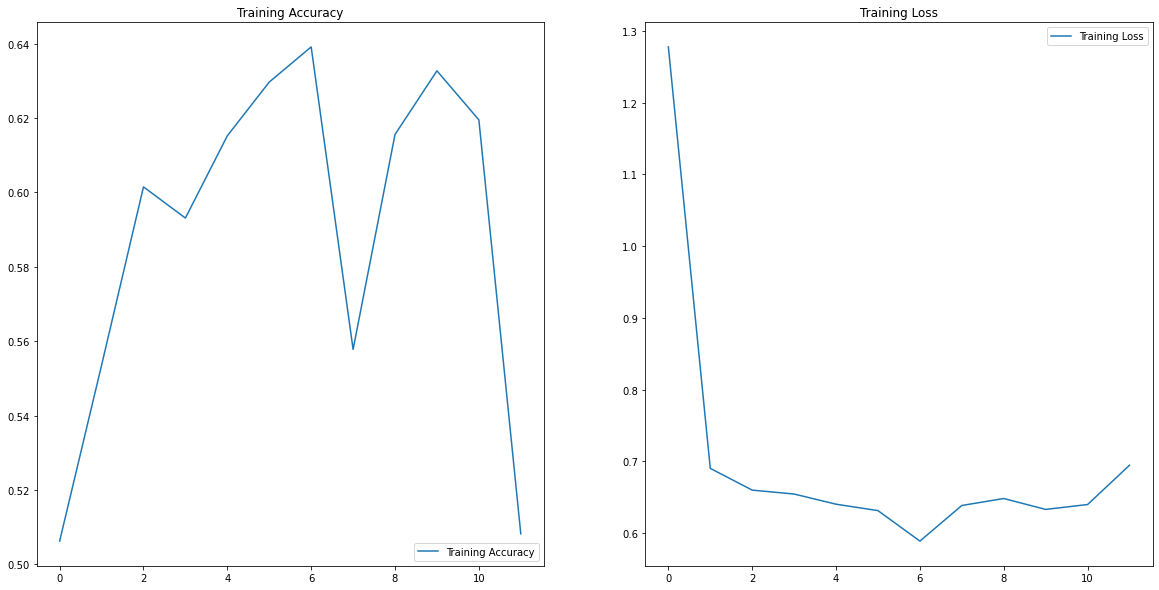

In [13]:
training_accuracy = history.history['accuracy']

training_loss = history.history['loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("model-1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-1.h5")
print("Saved model to disk")

Saved model to disk
